## Импорт данных и библиотек

In [35]:
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
contract = pd.read_csv("./data/contract.csv", index_col = "customerID")
internet = pd.read_csv("./data/internet.csv", index_col = "customerID")
personal = pd.read_csv("./data/personal.csv", index_col = "customerID")
phone = pd.read_csv("./data/phone.csv", index_col = "customerID")
data = {"contract":contract, "internet":internet,"personal":personal,"phone":phone}

In [3]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [4]:
for key,df in data.items():
    print(key)
    get_data_info(df)
    print("-"*50)

contract


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
5089-IFSDP,2015-01-01,2019-11-01 00:00:00,Two year,Yes,Bank transfer (automatic),109.45,6144.55
6969-MVBAI,2019-05-01,No,Month-to-month,Yes,Electronic check,90.10,816.8
4418-LZMSV,2019-01-01,No,Month-to-month,No,Bank transfer (automatic),61.80,750.1
7055-VKGDA,2015-05-01,2019-11-01 00:00:00,One year,Yes,Credit card (automatic),105.40,5643.4
3900-AQPHZ,2019-12-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,19.90,19.9


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


--------------------------------------------------
internet


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
3717-LNXKW,Fiber optic,Yes,No,No,No,Yes,No
2073-QBVBI,DSL,No,Yes,No,Yes,No,No
9269-CQOOL,DSL,No,No,No,No,Yes,No
0644-OQMDK,Fiber optic,No,No,No,No,No,No
1297-VQDRP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


--------------------------------------------------
personal


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
5445-PZWGX,Male,0,No,No
7025-IWFHT,Male,0,No,No
9489-JMTTN,Female,0,Yes,Yes
4698-KVLLG,Female,1,No,No
7508-DQAKK,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


--------------------------------------------------
phone


,MultipleLines
customerID,
8909-BOLNL,No
5834-ASPWA,Yes
0253-ZTEOB,Yes
5307-DZCVC,Yes
8735-DCXNF,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


--------------------------------------------------


**Вывод**

Пропусков нет. Следует рассмотреть столбец TotalCharges и привести его к числовому формату. Необходимо добавить признак об использовании телефонии или интернета. А также необходимо создать бинарный целевой признак.

Начнём с TotalCharges и найдем пользователей с пустыми полями.

In [5]:
contract[contract["TotalCharges"].str.isspace()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Заменим пропуски в столбце на месячный платёж и преобразуем формат данных в столбце.

In [6]:
contract["TotalCharges"].mask(contract["TotalCharges"].str.isspace(),contract["MonthlyCharges"],inplace=True)
contract["TotalCharges"] = pd.to_numeric(contract["TotalCharges"])
#df[‘column_name’].mask( df[‘column_name’] == ‘some_value’, value , inplace=True )

In [7]:
contract[contract["TotalCharges"] != ""].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(5)
memory usage: 440.2+ KB


Добавим бинарный признак для интернета и телефонии.

In [8]:
data['internet']['internet'] = 'Yes'
data['phone']['phone'] = 'Yes'

Объеденим всё в один датафрейм и удалим номер, т.к. бесполезный признак.

In [9]:
df = contract.join([data[i] for i in data.keys() if i != "contract"]).reset_index()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  internet          5517 non-null   object 
 16  gender            7043 non-null   object 


Заполним пропуски "No", потому что они обусловлены  объедением наборов данных по разным услугам.

In [11]:
df = df.fillna("No")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  internet          7043 non-null   object 
 16  gender            7043 non-null   object 


In [13]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

Найдём всех клиентов, которые ушли и остались. А также создадим целевой признак.

In [14]:
clientsLeft = df.loc[df['EndDate'] != 'No']
clientsStay = df.loc[df['EndDate'] == 'No']
df.loc[df['EndDate'] != 'No','exit'] = 1
df.loc[df['EndDate'] == 'No', 'exit'] = 0
df['exit'] = df['exit'].astype(int)

Для дальнейшего исследования данных имеет смысл добавить признак, который будет показывать какое время ушедшие клиенты пользовались услугами.

In [15]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01' # заменим для оставшихся клиентов, чтобы новый признак был равен 0
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeforeLeft'] = (df['EndDate'] - df['BeginDate']).dt.days
df = df.drop(columns=['BeginDate', 'EndDate']) # удалим эти столбцы из-за ненадобности

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  internet          7043 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null   object 


In [17]:
df.BeforeLeft.sort_values()

488        0
3331       0
1340       0
1082       0
3826       0
        ... 
4610    2191
6686    2191
3814    2191
3767    2191
5734    2191
Name: BeforeLeft, Length: 7043, dtype: int64

Рассмотрим уникальные значения в категориальных признаках.

In [18]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 'gender', 'OnlineBackup', 'Dependents',
              'PaperlessBilling', 'StreamingTV','MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod','phone', 'internet']

In [19]:
for i in categorial:
    print(i)
    print(df[i].unique())


Type
['Month-to-month' 'One year' 'Two year']
InternetService
['DSL' 'Fiber optic' 'No']
Partner
['Yes' 'No']
DeviceProtection
['No' 'Yes']
gender
['Female' 'Male']
OnlineBackup
['Yes' 'No']
Dependents
['No' 'Yes']
PaperlessBilling
['Yes' 'No']
StreamingTV
['No' 'Yes']
MultipleLines
['No' 'Yes']
SeniorCitizen
[0 1]
TechSupport
['No' 'Yes']
OnlineSecurity
['No' 'Yes']
StreamingMovies
['No' 'Yes']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
phone
['No' 'Yes']
internet
['Yes' 'No']


## Корреляция

Так как мы можем заметить, что у нас категориальных признаков куда больше, чем количественных, то не имеет смысла использовать коэффициент корреляции **Пиросона**. Более уместным будет использование коэффициента корреляции **Phi_K**. **Phi_K** позволяет
анализировать корреляцию между числовыми, категориальными, интервальными и порядковыми переменными, а также эффективно захватывает нелинейные зависимости.

In [20]:
phikCorrMatrix = df.drop(['customerID'], axis=1).phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'exit', 'BeforeLeft']


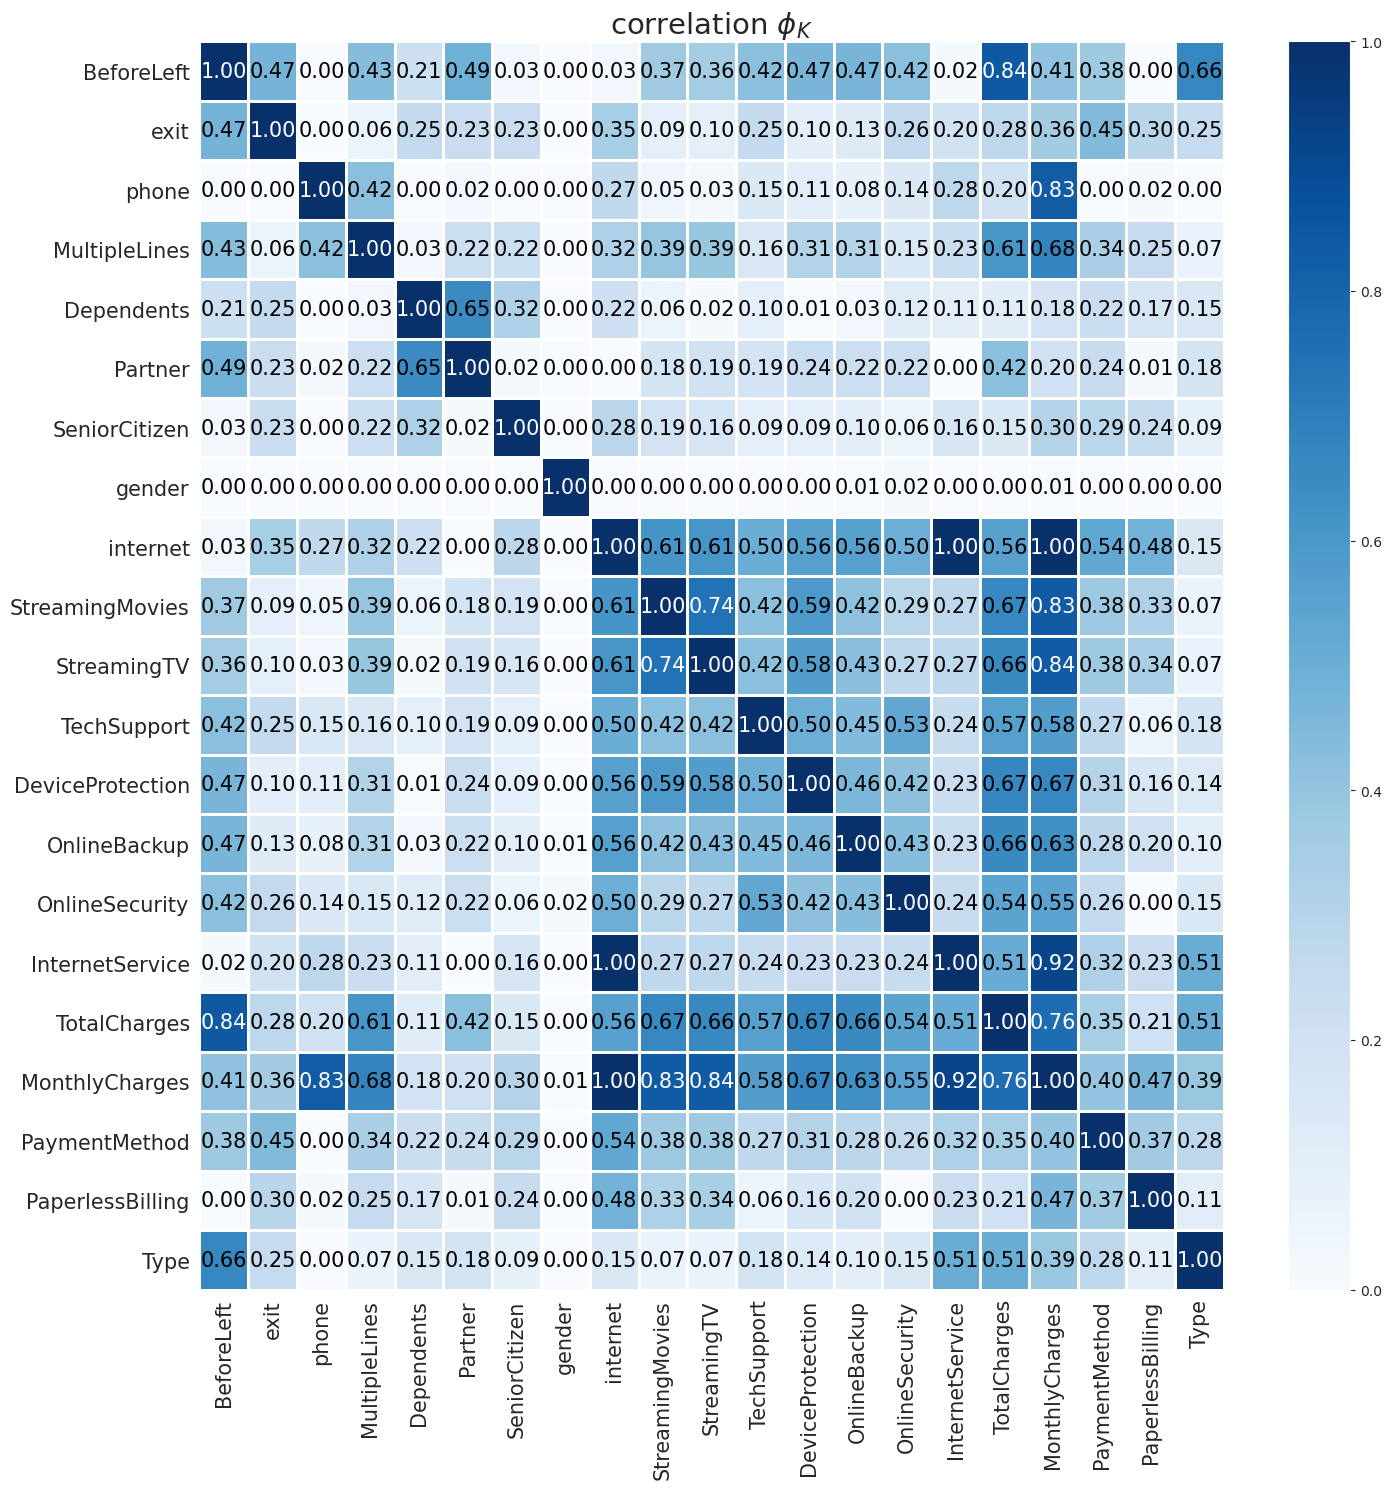

In [21]:
plot_correlation_matrix(phikCorrMatrix.values, x_labels=phikCorrMatrix.columns, y_labels=phikCorrMatrix.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))
plt.tight_layout()

Судя по матрице можем заметить, что добавленный нами ранее признак internet является практически дубликатом признака InternetService, поэтому мы должны удалить internet, т.к. он хоть и лучше коррелирует с целевым признаком, но из-за бинарности даёт не полную картину. Также стоит удалить признак TotalCharges, по той причине, что признака MonthlyCharges достаточно.

Рассмотрим конкретно корреляцию с целевым признаком.

In [22]:
phikCorrMatrix['exit'].sort_values()

phone               0.000000
gender              0.000000
MultipleLines       0.059581
StreamingMovies     0.093923
StreamingTV         0.096865
DeviceProtection    0.101516
OnlineBackup        0.126973
InternetService     0.196202
Partner             0.232930
SeniorCitizen       0.233432
Type                0.251639
Dependents          0.253936
TechSupport         0.254615
OnlineSecurity      0.264580
TotalCharges        0.279152
PaperlessBilling    0.295754
internet            0.349367
MonthlyCharges      0.360050
PaymentMethod       0.449125
BeforeLeft          0.474001
exit                1.000000
Name: exit, dtype: float64

Сильную корреляцию мы можем заметить с признаками BeforeLeft, PaymentMethod, MonthlyCharges. Меньше всего коррелируют пол, наличие телефонии и стриминговые услуги.

## Разделение выборки

In [23]:
df = df.drop('customerID',axis=1) # в дальнейшем нам вряд ли понадобится этот признак
train, test = train_test_split(
    df, train_size=0.7, random_state=42, stratify=df['exit'])


In [24]:
val, test = train_test_split(
    test, train_size=0.5, random_state=42, stratify=test['exit'])

Убедимся в адекватности разделения нашей выборки, рассмотрев средние значения.

In [25]:
print(train['exit'].mean())
print(test['exit'].mean())
print(val['exit'].mean())

0.2653144016227181
0.26584673604541154
0.26515151515151514


## Обучение модели

In [26]:
train_pool = Pool(data=train.drop('exit',axis=1),label=train['exit'], cat_features=categorial)
test_pool = Pool(data=test.drop('exit',axis=1),label=test['exit'], cat_features=categorial)
val_pool = Pool(data=val.drop('exit',axis=1),label=val['exit'], cat_features=categorial)

In [31]:
model = CatBoostClassifier(iterations=1000,
                            loss_function='Logloss',
                            eval_metric='F1',
                            logging_level='Verbose',
                           task_type="CPU",
                           thread_count=-1,
                           metric_period=100
                           )

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,]}

model.grid_search(grid,train_pool,plot=True)

model.fit(train_pool,
          eval_set=val_pool,
          plot=True,
          silent=False)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5549846	test: 0.5489362	best: 0.5489362 (0)	total: 3.37ms	remaining: 3.37s
100:	learn: 0.6113292	test: 0.6285714	best: 0.6285714 (100)	total: 359ms	remaining: 3.19s
200:	learn: 0.6554713	test: 0.6484018	best: 0.6484018 (200)	total: 665ms	remaining: 2.64s
300:	learn: 0.6767568	test: 0.6529680	best: 0.6529680 (300)	total: 920ms	remaining: 2.13s
400:	learn: 0.6964478	test: 0.6621005	best: 0.6621005 (400)	total: 1.18s	remaining: 1.75s
500:	learn: 0.7135193	test: 0.6620370	best: 0.6621005 (400)	total: 1.41s	remaining: 1.4s
600:	learn: 0.7262989	test: 0.6728111	best: 0.6728111 (600)	total: 1.64s	remaining: 1.08s
700:	learn: 0.7389215	test: 0.6789838	best: 0.6789838 (700)	total: 1.89s	remaining: 806ms
800:	learn: 0.7495996	test: 0.6880734	best: 0.6880734 (800)	total: 2.15s	remaining: 534ms
900:	learn: 0.7631719	test: 0.7000000	best: 0.7000000 (900)	total: 2.39s	remaining: 262ms
999:	learn: 0.7725824	test: 0.7074830	best: 0.7074830 (999)	total: 2.6s	remaining: 0us

bestTest = 0.707

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3945355	test: 0.3890274	best: 0.3890274 (0)	total: 3.72ms	remaining: 3.72s
100:	learn: 0.6730938	test: 0.6412826	best: 0.6412826 (100)	total: 203ms	remaining: 1.8s
200:	learn: 0.7276670	test: 0.6891089	best: 0.6891089 (200)	total: 388ms	remaining: 1.54s
300:	learn: 0.7763102	test: 0.7131474	best: 0.7131474 (300)	total: 587ms	remaining: 1.36s
400:	learn: 0.8047438	test: 0.7254509	best: 0.7254509 (400)	total: 784ms	remaining: 1.17s
500:	learn: 0.8271501	test: 0.7341270	best: 0.7341270 (500)	total: 1.01s	remaining: 1s
600:	learn: 0.8452830	test: 0.7380952	best: 0.7380952 (600)	total: 1.19s	remaining: 793ms
700:	learn: 0.8634288	test: 0.7450199	best: 0.7450199 (700)	total: 1.4s	remaining: 599ms
800:	learn: 0.8802962	test: 0.7454910	best: 0.7454910 (800)	total: 1.61s	remaining: 399ms
900:	learn: 0.8867925	test: 0.7539683	best: 0.7539683 (900)	total: 1.81s	remaining: 199ms
999:	learn: 0.8983258	test: 0.7485149	best: 0.7539683 (900)	total: 2.01s	remaining: 0us

bestTest = 0.753968

In [34]:
m = model.predict(test)


In [37]:
m

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
accuracy_score(test['exit'],m)

0.8722800378429517